In [38]:
from tokam2d_utils import TokamDataset
import torch
from tqdm import tqdm 
from pathlib import Path
from torchvision import tv_tensors


In [2]:

data_path_train = Path("input_data/train")
data_path_test = Path("input_data/private_test")
test_f = Path("input_data/test")

train_ds = TokamDataset(data_path_train)
test_ds = TokamDataset(data_path_test)
test_f = TokamDataset(test_f)

Found annotations for 30 frames in 2 files.


Loaded 30 frames.
No label files found
Loaded 4 frames.
No label files found
Loaded 4 frames.


blob_i-50


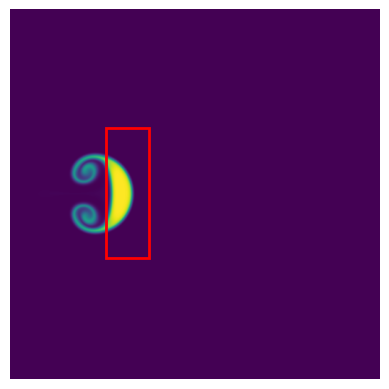

blob_i-100


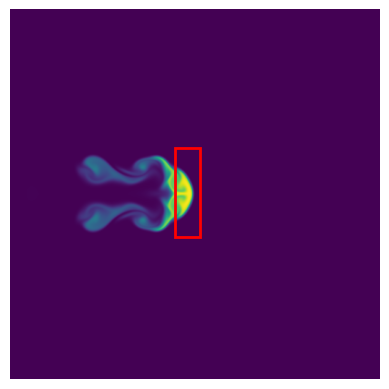

blob_i-150


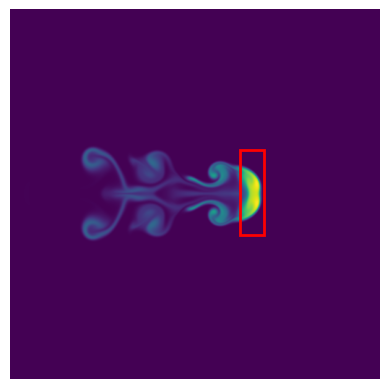

blob_i-200


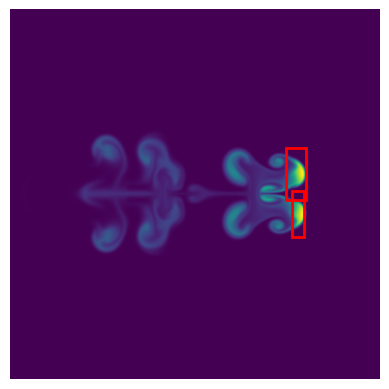

blob_i-250


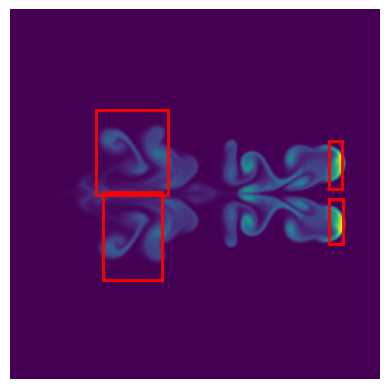

blob_i-300


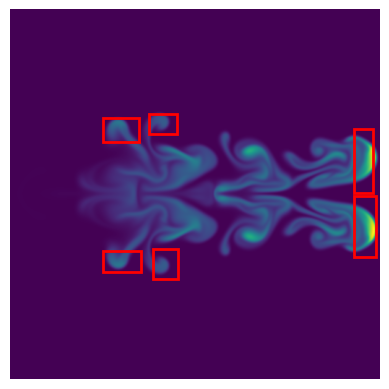

blob_i-350


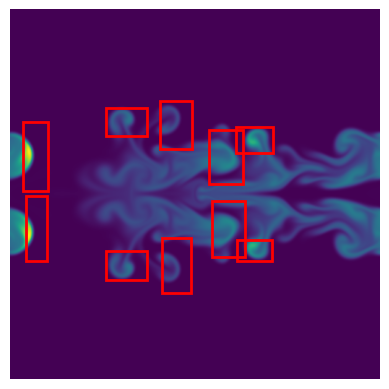

blob_i-400


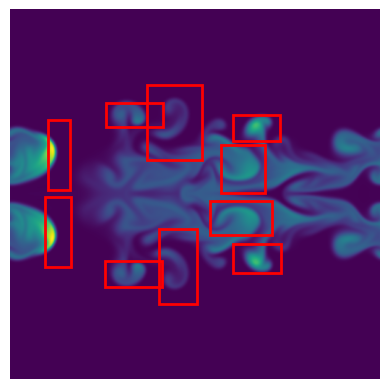

blob_i-450


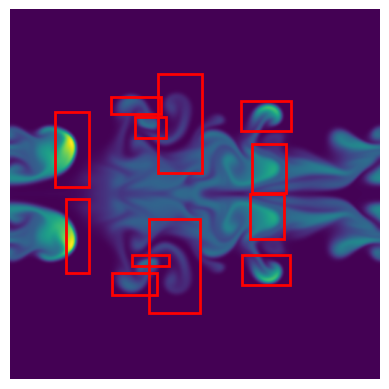

blob_i-500


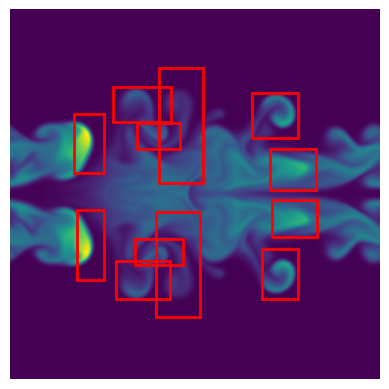

blob_i-550


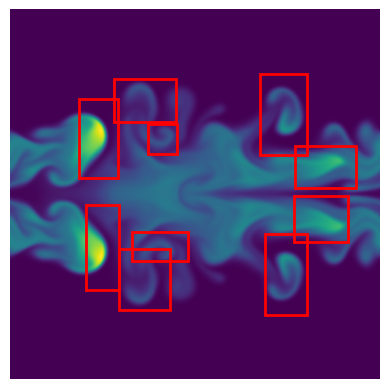

blob_i-600


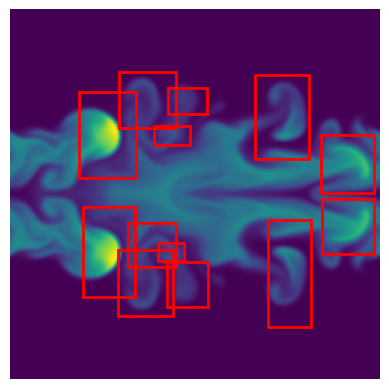

blob_i-650


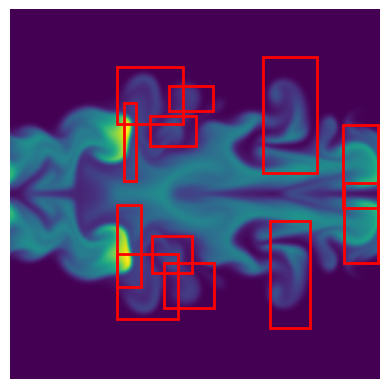

blob_i-700


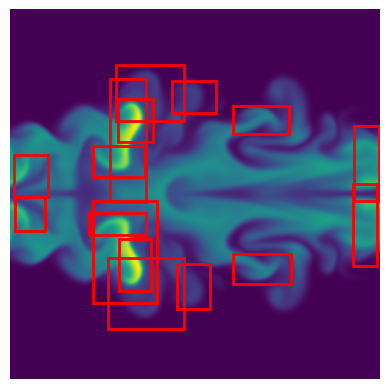

blob_i-750


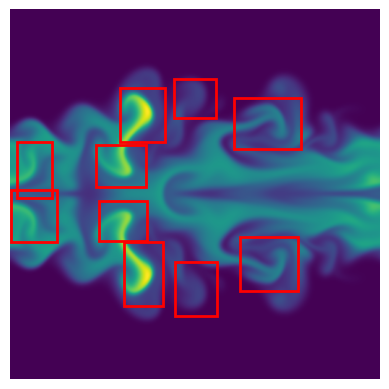

blob_i-800


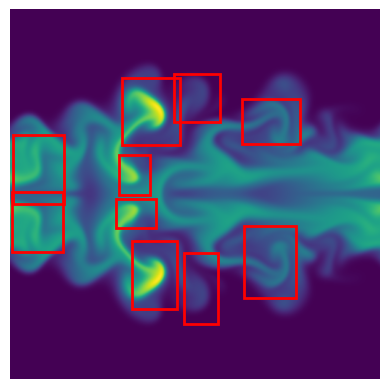

blob_i-850


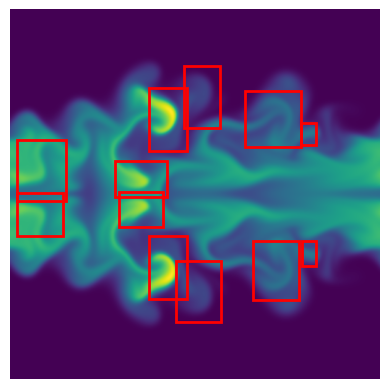

blob_i-900


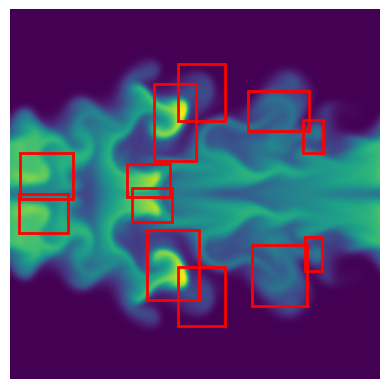

blob_i-950


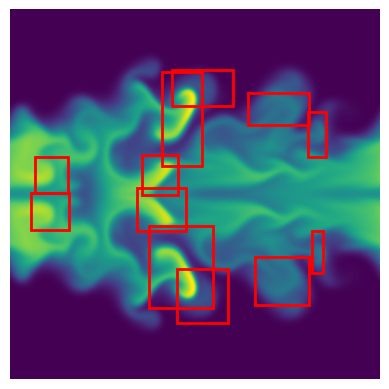

blob_i-1000


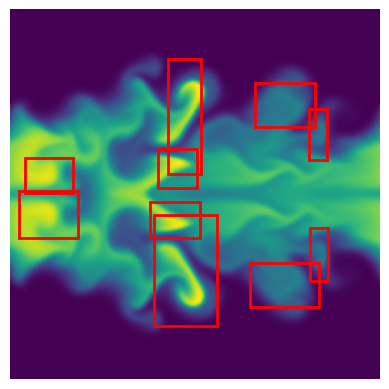

blob_dwi-50


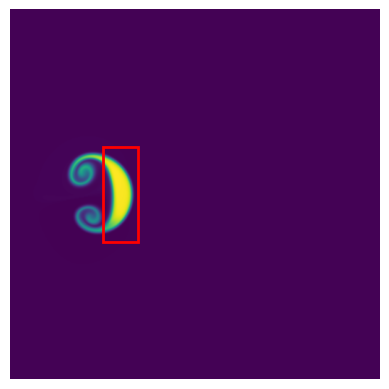

blob_dwi-150


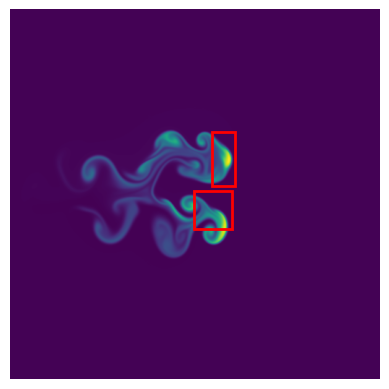

blob_dwi-250


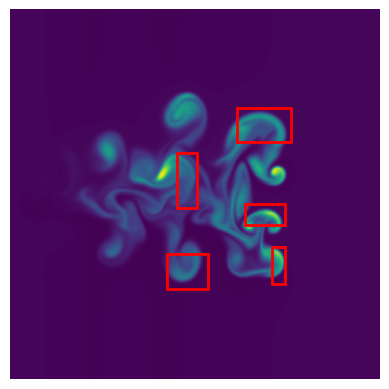

blob_dwi-350


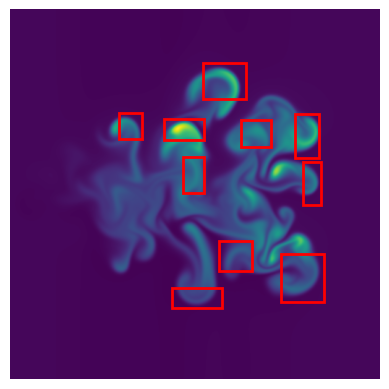

blob_dwi-450


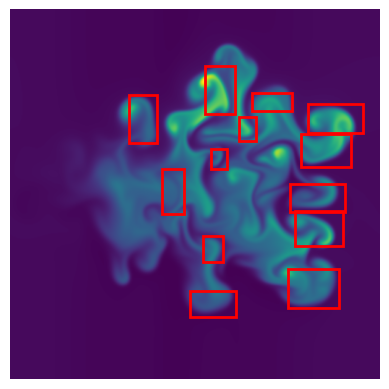

blob_dwi-550


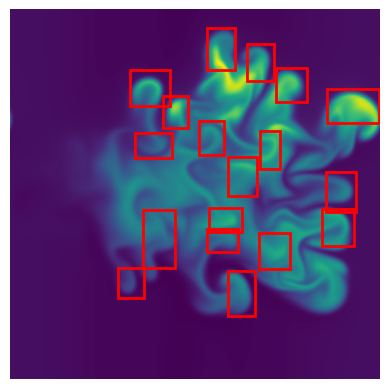

blob_dwi-650


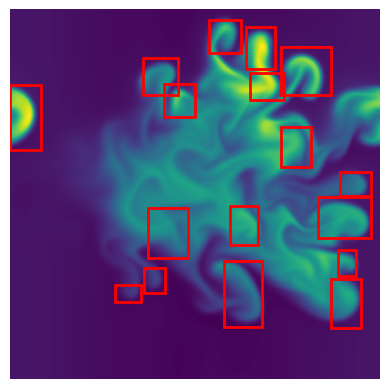

blob_dwi-750


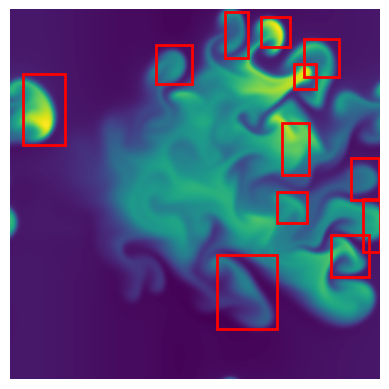

blob_dwi-850


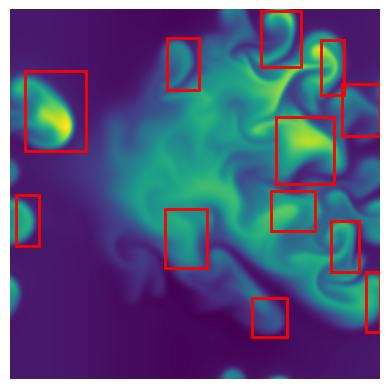

blob_dwi-950


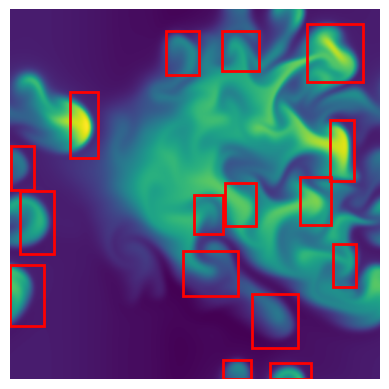

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for data in train_ds:
    image = data[0].squeeze().cpu().numpy()
    annotations = data[1]
    bboxes = annotations['boxes']
    print(annotations["frame_index"])
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for box in bboxes:
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        
        rect = patches.Rectangle(
            (xmin, ymin), 
            width, 
            height, 
            linewidth=2, 
            edgecolor='r', 
            facecolor='none'
        )
        ax.add_patch(rect)
        
    plt.axis('off')
    plt.show()

In [32]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, trainable_backbone_layers=0, box_score_thresh=0.05)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [33]:
from torchvision.transforms import v2


def get_transforms(train=True):
    transforms = []
    if train:
        transforms.append(v2.RandomHorizontalFlip(0.5))
        transforms.append(v2.RandomVerticalFlip(0.5))
        transforms.append(v2.RandomAffine(
                degrees=180, 
                translate=(0.2, 0.2), 
                scale=(0.3, 2.0),
                shear=10
            ))
    
    transforms.append(v2.ToDtype(torch.float32, scale=True))
    transforms.append(v2.SanitizeBoundingBoxes()) 
    
    return v2.Compose(transforms)

final_transform = get_transforms()

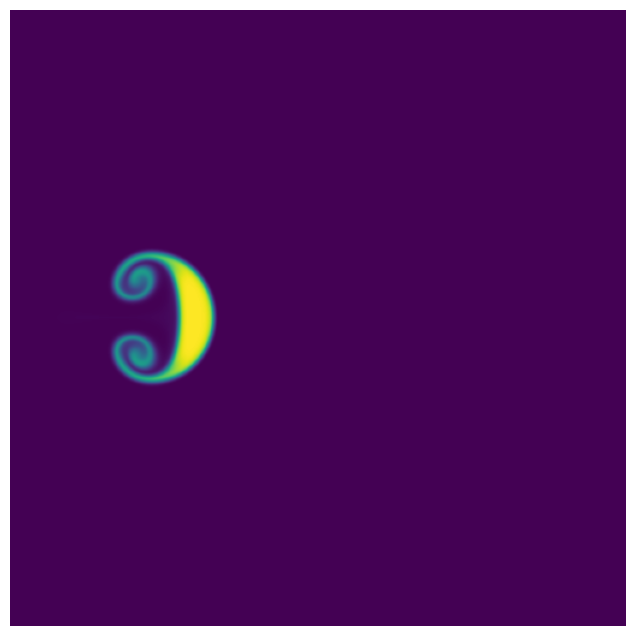

In [16]:
plt.figure(figsize=(12, 8))
plt.imshow(train_ds[0][0].squeeze().cpu())
plt.axis("off")
plt.show()

torch.Size([3, 512, 512])


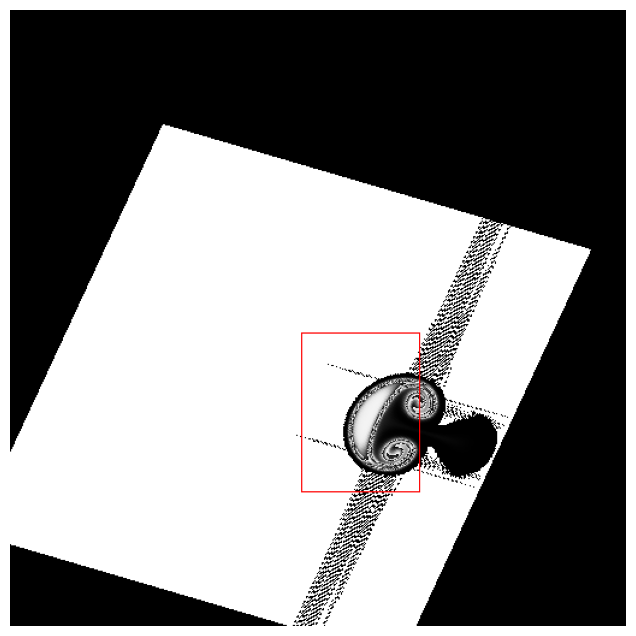

In [28]:
transform_image = final_transform(train_ds[0][0],train_ds[0][1])
box = draw_bounding_boxes(transform_image[0], boxes=transform_image[1]["boxes"],
                          colors="red")
print(box.shape)
box = box.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(12, 8))
plt.imshow(box)
plt.axis("off")
plt.show()

In [41]:
import random
class MosaicWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, output_size=(512, 512)):
        self.dataset = dataset
        self.output_size = output_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        indices = [idx] + [random.randint(0, len(self.dataset) - 1) for _ in range(3)]
        
        images = []
        boxes_list = []
        
        for k in indices:
            img, target = self.dataset[k]
            images.append(img)
            boxes_list.append(target["boxes"])

        c, h, w = images[0].shape
        mosaic_img = torch.full((c, h * 2, w * 2), 0.0, dtype=images[0].dtype)
        offsets = [(0, 0), (0, w), (h, 0), (h, w)]
        new_boxes = []

        for img, boxes, (off_y, off_x) in zip(images, boxes_list, offsets):
            mosaic_img[:, off_y:off_y+h, off_x:off_x+w] = img
            shifted_boxes = boxes.clone()
            shifted_boxes[:, 0] += off_x
            shifted_boxes[:, 2] += off_x
            shifted_boxes[:, 1] += off_y
            shifted_boxes[:, 3] += off_y
            new_boxes.append(shifted_boxes)

        all_boxes = torch.cat(new_boxes, dim=0)
        
        data = {
            "image": tv_tensors.Image(mosaic_img),
            "boxes": tv_tensors.BoundingBoxes(
                all_boxes,
                format="XYXY",
                canvas_size=(h * 2, w * 2)
            ),
            "labels": torch.ones((all_boxes.shape[0],), dtype=torch.int64)
        }
        
        mosaic_transforms = v2.Compose([
            v2.Resize(self.output_size),
            v2.SanitizeBoundingBoxes()
        ])
        
        transformed_data = mosaic_transforms(data)
        
        return transformed_data["image"], {
            "boxes": transformed_data["boxes"],
            "labels": transformed_data["labels"]
        }

In [80]:
import torch
from torchvision import tv_tensors
def collate_fn(batch: torch.Tensor) -> torch.Tensor:
    return tuple(zip(*batch))

mosaic_dataset = MosaicWrapper(train_ds, output_size=(512, 512))
train_dataloader = torch.utils.data.DataLoader(
        mosaic_dataset, batch_size=4, collate_fn=collate_fn, shuffle=True
    )

model.to("cuda" if torch.cuda.is_available() else "cpu")
model.train()

optimizer = torch.optim.AdamW(model.parameters())

max_epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"


for i in range(max_epochs):
    print(f"Epoch {i+1}/{max_epochs}")
    running_loss = 0.0
    
    for batch_idx, (images, targets) in enumerate(train_dataloader):
        
        aug_images = []
        aug_targets = []

        for img, target in zip(images, targets):

            img = img.to(device)
            target = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in target.items()}
            img_tv = tv_tensors.Image(img)
            target["boxes"] = tv_tensors.BoundingBoxes(
                target["boxes"], 
                format="XYXY", 
                canvas_size=img.shape[-2:]
            )
            
            new_img, new_target = final_transform(img_tv, target)
            
            aug_images.append(new_img)
            aug_targets.append(new_target)
            
        optimizer.zero_grad()
        
        loss_dict = model(aug_images, aug_targets)
        
        full_loss = sum(loss for loss in loss_dict.values())
        running_loss += full_loss.item()
        
        full_loss.backward()
        optimizer.step()

    print(f"Loss moyenne: {running_loss / len(train_dataloader):.4f}")

model.eval().to("cpu")


Epoch 1/50
Loss moyenne: 1.3190
Epoch 2/50
Loss moyenne: 1.3865
Epoch 3/50
Loss moyenne: 1.3217
Epoch 4/50
Loss moyenne: 1.2952
Epoch 5/50
Loss moyenne: 1.3075
Epoch 6/50
Loss moyenne: 1.3875
Epoch 7/50
Loss moyenne: 1.4325
Epoch 8/50
Loss moyenne: 1.3978
Epoch 9/50
Loss moyenne: 1.3581
Epoch 10/50
Loss moyenne: 1.3737
Epoch 11/50
Loss moyenne: 1.3166
Epoch 12/50
Loss moyenne: 1.3050
Epoch 13/50
Loss moyenne: 1.2838
Epoch 14/50
Loss moyenne: 1.2882
Epoch 15/50
Loss moyenne: 1.3480
Epoch 16/50
Loss moyenne: 1.3392
Epoch 17/50
Loss moyenne: 1.3304
Epoch 18/50
Loss moyenne: 1.3062
Epoch 19/50
Loss moyenne: 1.3263
Epoch 20/50
Loss moyenne: 1.2259
Epoch 21/50
Loss moyenne: 1.2769
Epoch 22/50
Loss moyenne: 1.2787
Epoch 23/50
Loss moyenne: 1.2787
Epoch 24/50
Loss moyenne: 1.3102
Epoch 25/50
Loss moyenne: 1.2645
Epoch 26/50
Loss moyenne: 1.2451
Epoch 27/50
Loss moyenne: 1.3151
Epoch 28/50
Loss moyenne: 1.2613
Epoch 29/50
Loss moyenne: 1.3498
Epoch 30/50
Loss moyenne: 1.3257
Epoch 31/50
Loss mo

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [169]:
model = fasterrcnn_resnet50_fpn_v2(trainable_backbone_layers=2, box_score_thresh=0.05)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("faster_rcnn_tokam.pth", map_location=device))
model.eval()

/Volumes/Mac_ext/code_courses/data_camp/.venv/lib/python3.12/site-packages/torchvision/models/detection/backbone_utils.py:162: UserWarning: Changing trainable_backbone_layers has no effect if neither pretrained nor pretrained_backbone have been set to True, falling back to trainable_backbone_layers=5 so that all layers are trainable
  warnings.warn(


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [9]:
import torch

def box_area(boxes):
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def box_iomean(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    denom = area1[:, None] + area2
    return 2 * inter / (denom + 1e-6)

def compute_ap50_iomean(pred_boxes_list, pred_scores_list, gt_boxes_list, iomean_threshold=0.5):
    scores, true_positives, num_gt = [], [], 0
    for pred_boxes, pred_scores, gt_boxes in zip(pred_boxes_list, pred_scores_list, gt_boxes_list):
        num_gt += len(gt_boxes)
        if len(pred_boxes) == 0: continue
        scores.append(pred_scores)
        if len(gt_boxes) == 0:
            true_positives.append(torch.zeros(len(pred_boxes), device=pred_boxes.device))
            continue
            
        iomean_matrix = box_iomean(pred_boxes, gt_boxes)
        values, indices = torch.sort(pred_scores, descending=True)
        pred_boxes, pred_scores = pred_boxes[indices], pred_scores[indices]
        iomean_matrix = iomean_matrix[indices]
        
        tp = torch.zeros(len(pred_boxes), device=pred_boxes.device)
        gt_matched = torch.zeros(len(gt_boxes), dtype=torch.bool, device=gt_boxes.device)

        for i in range(len(pred_boxes)):
            max_val, max_idx = torch.max(iomean_matrix[i], dim=0)
            if max_val >= iomean_threshold and not gt_matched[max_idx]:
                tp[i] = 1
                gt_matched[max_idx] = True
        true_positives.append(tp)

    if num_gt == 0: return 0.0
    scores = torch.cat(scores)
    true_positives = torch.cat(true_positives)
    indices = torch.argsort(scores, descending=True)
    true_positives = true_positives[indices]
    
    tp_cumsum = torch.cumsum(true_positives, dim=0)
    fp_cumsum = torch.cumsum(1 - true_positives, dim=0)
    recalls = tp_cumsum / num_gt
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    
    return torch.trapz(precisions, recalls).item() 




[tensor([0.9677, 0.9430, 0.9399, 0.9354, 0.9308, 0.9109, 0.8997, 0.8887, 0.8835,
        0.8698, 0.8189, 0.8003, 0.7978, 0.7712, 0.7413, 0.7227, 0.7151, 0.7126,
        0.6347, 0.6343, 0.6281, 0.5475, 0.5432, 0.5361, 0.5327, 0.4953, 0.4893,
        0.4788, 0.4772, 0.4602, 0.4578, 0.4462, 0.3905, 0.3842, 0.3453, 0.3084,
        0.2842, 0.2611, 0.2607, 0.2557, 0.2359, 0.2154, 0.2044, 0.2032, 0.1951,
        0.1868, 0.1708, 0.1694, 0.1606, 0.1520, 0.1481, 0.1423, 0.1339, 0.1331,
        0.1098, 0.1027, 0.0875, 0.0771, 0.0720, 0.0714, 0.0698, 0.0690, 0.0679,
        0.0675, 0.0667, 0.0648, 0.0634, 0.0626, 0.0596, 0.0595, 0.0564, 0.0557,
        0.0557, 0.0548, 0.0540, 0.0535, 0.0532, 0.0519, 0.0502],
       device='cuda:0')]
Score IoMean AP50 pour cette image : 0.7538


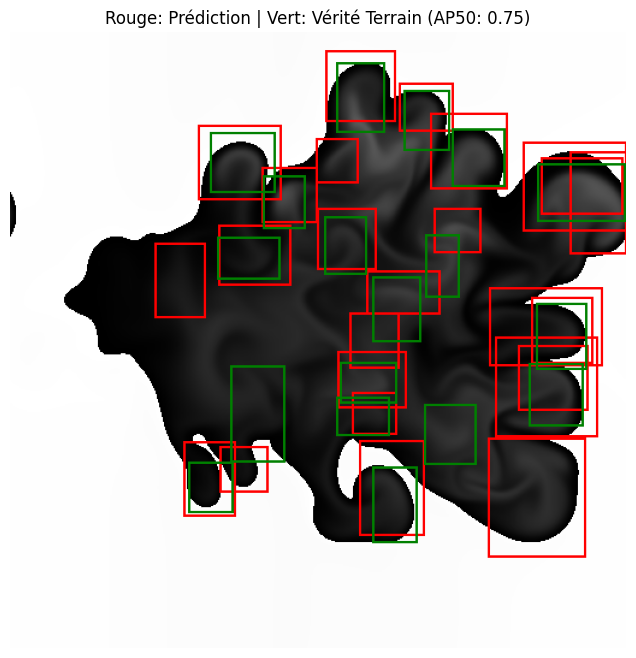

In [81]:
img, target_gt = train_ds[25] 

preprocess = weights.transforms()
batch = [preprocess(img).to(device)]
model = model.to(device)
with torch.no_grad():
    prediction = model(batch)[0]

pred_boxes_list = [prediction["boxes"]]
pred_scores_list = [prediction["scores"]]
print(pred_scores_list)
gt_boxes_list = [target_gt["boxes"].to(device)]

score_ap50 = compute_ap50_iomean(pred_boxes_list, pred_scores_list, gt_boxes_list)

print(f"Score IoMean AP50 pour cette image : {score_ap50:.4f}")

from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

img_uint8 = (img * 255).to(torch.uint8) 

keep = prediction["scores"] > 0.5
pred_img = draw_bounding_boxes(img_uint8, boxes=prediction["boxes"][keep], colors="red", width=2)

final_img = draw_bounding_boxes(pred_img, boxes=target_gt["boxes"], colors="green", width=2)

plt.figure(figsize=(12, 8))
plt.imshow(final_img.permute(1, 2, 0).cpu().numpy())
plt.title(f"Rouge: Prédiction | Vert: Vérité Terrain (AP50: {score_ap50:.2f})")
plt.axis("off")
plt.show()

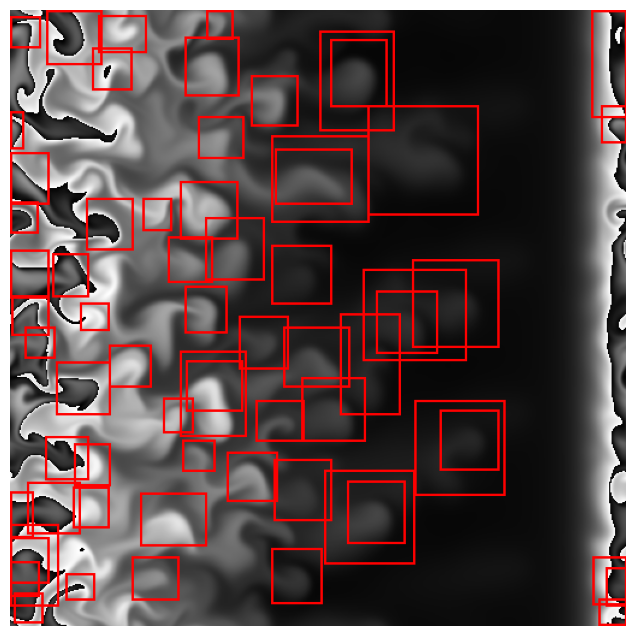

In [82]:
img, target_gt = test_ds[0] 

preprocess = weights.transforms()
batch = [preprocess(img).to(device)]
prediction = model(batch)[0]

img_uint8 = (img * 255).to(torch.uint8) 

keep = prediction["scores"] > 0.5
pred_img = draw_bounding_boxes(img_uint8, boxes=prediction["boxes"][keep], colors="red", width=2)
plt.figure(figsize=(12, 8))
plt.imshow(pred_img.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()


In [47]:
print(mosaic_dataset[0])

(Image([[[1.0000, 1.0000, 1.0000,  ..., 0.9974, 0.9974, 0.9975],
        [1.0000, 1.0000, 1.0000,  ..., 0.9974, 0.9974, 0.9975],
        [1.0000, 1.0000, 1.0000,  ..., 0.9974, 0.9974, 0.9975],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]], ), {'boxes': BoundingBoxes([[ 66.3800,  81.5950,  96.1600, 172.2100],
               [297.2350,  57.0100, 316.5950, 102.9050],
               [262.4550, 125.4950, 286.1200, 169.2350],
               [256.7200,  94.6600, 272.4950, 124.7750],
               [256.0000, 176.7650, 279.3100, 218.7150],
               [403.0050, 242.3800, 422.7250, 256.0000],
               [435.6350, 244.8900, 463.9600, 256.0000],
               [456.4300, 116.1700, 478.3000, 148.8000],
               [477.5850,  76.3750, 493.7200, 118.3250],
               [461.4500,  10.0450, 500.5300,  49.8400],
               [4

In [39]:


model.to(device)
model.eval()

all_pred_boxes = []
all_pred_scores = []
all_gt_boxes = []

print("Calcul des prédictions sur tout le dataset...")

for i in tqdm(range(len(train_ds))):
    img, target_gt = train_ds[i]
    preprocess = weights.transforms()
    batch = [preprocess(img).to(device)]
    
    with torch.no_grad():
        prediction = model(batch)[0]
    
    all_pred_boxes.append(prediction["boxes"].cpu())
    all_pred_scores.append(prediction["scores"].cpu())
    all_gt_boxes.append(target_gt["boxes"].cpu())
global_ap50 = compute_ap50_iomean(all_pred_boxes, all_pred_scores, all_gt_boxes)

print(f"\nMean Average Precision (AP50 IoMean) global : {global_ap50:.4f}")

Calcul des prédictions sur tout le dataset...


100%|██████████| 30/30 [00:01<00:00, 17.05it/s]


Mean Average Precision (AP50 IoMean) global : 0.7450


In [ ]:
PATH = "faster_rcnn_tokam.pth"
torch.save(model.state_dict(), PATH)
print(f"Modèle sauvegardé sous : {PATH}")

Modèle sauvegardé sous : faster_rcnn_tokam.pth
